<a href="https://colab.research.google.com/github/davidsjohnson/wise24_xai_ac/blob/main/notebooks/tutorial_image_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining Facial Expression Recognition
# Notebook 1:  XAI for Affective Computing (SoSe2024)

In this notebook you will attempt to generate explanations for predictions of two Facial Expression recognition models, one for tabular (structured) data extracted from images and one for raw image data, both trained using a subset of the [AffectNet dataset](http://mohammadmahoor.com/affectnet/). AffectNet is an image dataset of facial expressions in the wild, and is labeled with 8 facial expression categories: **Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, and Contempt**. (Have a look at the paper for more details https://arxiv.org/abs/1708.03985). 

The features used for prediction are facial action units (AUs). If you are not familiar with them, [this blog post](https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/) is a great resource to learn about the Facial Action Coding System (FACS). In short, they are a set of miniscule movements that the face can make. Loosely related to facial muscles, different actions of the same muscle can also have different units while most actions include more than one muscle.

More information will be provided in the tutorials. This is meant to get you familar with the dataset and models being used.

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

See **README** to get started with the Notebook setup

## Notebook Setup

Make sure to uncomment code based on if you are running locally or via Google Colab

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    !git clone https://github.com/davidsjohnson/xai_ac_wise25.git
# fix xgboost incompatiblity issue
    %pip uninstall -y -q scikit-learn
    %pip install -q scikit-learn==1.5.2

In [2]:
import sys
import os
if IN_COLAB:
  sys.path.append(os.path.realpath('xai_ac_wise25'))
else:
  sys.path.append(os.path.realpath('../'))

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io

import utils
import img_utils
import models
import evaluate
base_dir = Path('../data/') if not IN_COLAB else Path('xai_ac_wise25/data/')

## Data Loading

### Loading Images and Action Units

In the next cell, you will load csv files that contain extracted actions units and paths to the corresponding images.  

In [4]:

# Full data from training and evaluation
train_csv = base_dir / 'affectnet_aus/train_aus.csv'
val_csv = base_dir / 'affectnet_aus/val_aus.csv'

# load training and validation data as pandas dataframes
# action units extracted from the AffectNet dataset via OpenFace
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)

# smaller dataset for explanations
xai_csv = base_dir / 'affectnet_aus/eval_aus.csv'
df_xai = pd.read_csv(xai_csv)
df_xai['image'] = df_xai['image'].str.replace('../data', str(base_dir))

# get only the columns storing action units from the dataframe
# there are also facial landmarks and other features in the dataset could be useful
# but we igore them for now and focus on action units
feature_names = [col for col in df_val.columns if col.startswith('AU')]
categorical_features = [feat for feat in feature_names if '_c' in feat]
categorical_idxs = [i for i, feat in enumerate(feature_names) if '_c' in feat]

# setup categorical features for XGBoost
for feat in categorical_features:
    df_train[feat] = df_train[feat].astype('category')
    df_val[feat] = df_val[feat].astype('category')

# get the class labels
class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # same class labels as before

# Gets all images from folder used for XAI tasks
images = [io.imread(f) for f in df_xai.image]

In [5]:
feature_names

['AU01_r',
 'AU02_r',
 'AU04_r',
 'AU05_r',
 'AU06_r',
 'AU07_r',
 'AU09_r',
 'AU10_r',
 'AU12_r',
 'AU14_r',
 'AU15_r',
 'AU17_r',
 'AU20_r',
 'AU23_r',
 'AU25_r',
 'AU26_r',
 'AU45_r',
 'AU01_c',
 'AU02_c',
 'AU04_c',
 'AU05_c',
 'AU06_c',
 'AU07_c',
 'AU09_c',
 'AU10_c',
 'AU12_c',
 'AU14_c',
 'AU15_c',
 'AU17_c',
 'AU20_c',
 'AU23_c',
 'AU25_c',
 'AU26_c',
 'AU28_c',
 'AU45_c']

## XAI for Tabular Data

In this part, we will generate explanations for the XGBoost model trained using a dataset of Facial Action Units (as described in the notebook introduction).  

First, let's load the data and the trained models. Then we will evaluate the model peformance, before we start with the explanations.

In [6]:
from xgboost import XGBClassifier

### Setup the Datasets

In [7]:
X_train = df_train[feature_names]
y_train = df_train['class']
X_test = df_val[feature_names]
y_test = df_val['class']

X_xai = df_xai[feature_names]
y_xai = df_xai['class']

print('Training data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)
print('XAI data shape:', X_xai.shape, y_xai.shape)

Training data shape: (36685, 35) (36685,)
Test data shape: (3908, 35) (3908,)
XAI data shape: (80, 35) (80,)


### Train the Model

Now let's train the XGBoost Model on the split dataset. The accuracy of the model in the training data should be around $92\%$

In [8]:
# # Train model from scratch
random_state = 10
clf = XGBClassifier(booster='gbtree', enable_categorical=True, max_depth=15, eta=0.1, reg_lambda=30, random_state=random_state)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9220934987051929

### Evaluate the Model

Now we will evaluate it on the test dataset. Unfortunately, the accuracy is only $44\%$ but this is still well above chance guessing which would be $1 / 8 * 100 = 12.5\%$ accuracy (since there are 8 total classes)

In [9]:
# get model predictions
y_test_preds = clf.predict(X_test)
y_test_true = y_test

# eval results
print(classification_report(y_test_true, y_test_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.34      0.41      0.37       485
       Happy       0.57      0.68      0.62       488
         Sad       0.39      0.43      0.41       490
    Surprise       0.44      0.43      0.44       488
        Fear       0.48      0.46      0.47       487
     Disgust       0.50      0.35      0.41       493
       Anger       0.36      0.42      0.39       482
    Contempt       0.44      0.32      0.37       495

    accuracy                           0.44      3908
   macro avg       0.44      0.44      0.43      3908
weighted avg       0.44      0.44      0.43      3908



We can also review the confusion matrix to see where the model makes its mistakes

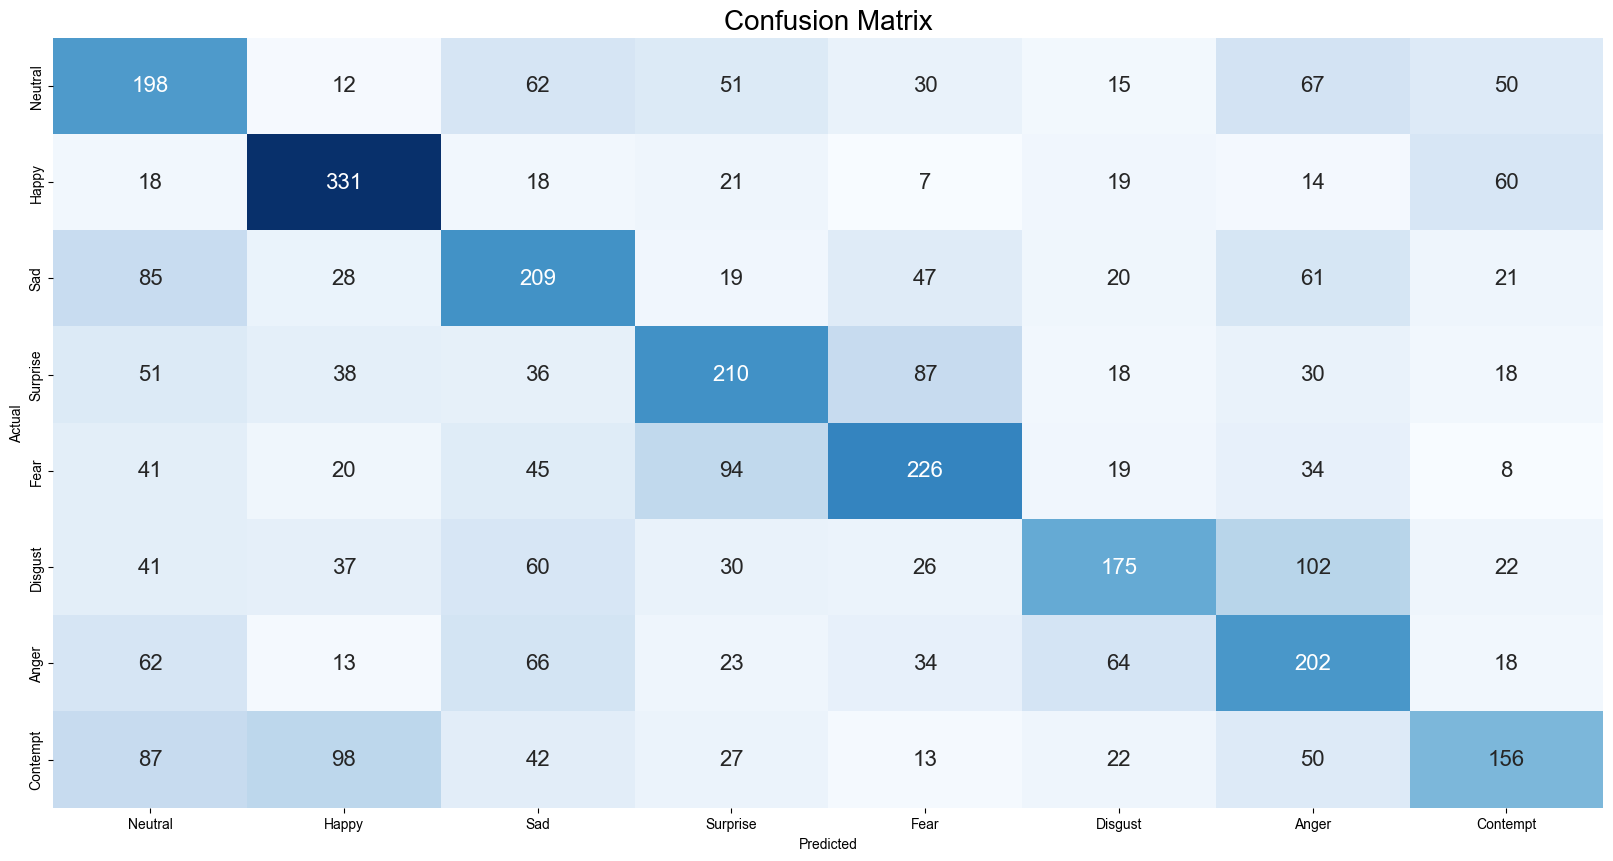

In [10]:
cm_data = confusion_matrix(y_test_true, y_test_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Setup XAI dataset and Predictions

In [11]:
# Evaluate model on XAI data
y_xai_preds = clf.predict(X_xai)
y_xai_true = y_xai

df_xai['xgb_pred'] = y_xai_preds

print(classification_report(y_xai_true, y_xai_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.12      0.20      0.15        10
       Happy       0.55      0.60      0.57        10
         Sad       0.45      0.50      0.48        10
    Surprise       0.62      0.50      0.56        10
        Fear       0.60      0.60      0.60        10
     Disgust       0.50      0.40      0.44        10
       Anger       0.10      0.10      0.10        10
    Contempt       0.50      0.30      0.38        10

    accuracy                           0.40        80
   macro avg       0.43      0.40      0.41        80
weighted avg       0.43      0.40      0.41        80



### Preview the Dataset with Predictions

The code below will display images from the XAI dataset.
- Try changing value of `start` to get a new set of images (there are 10 images for each class; for example, the class happy will be at indexes 10-19)
- Search through the images to find some that might be interesting to Explain

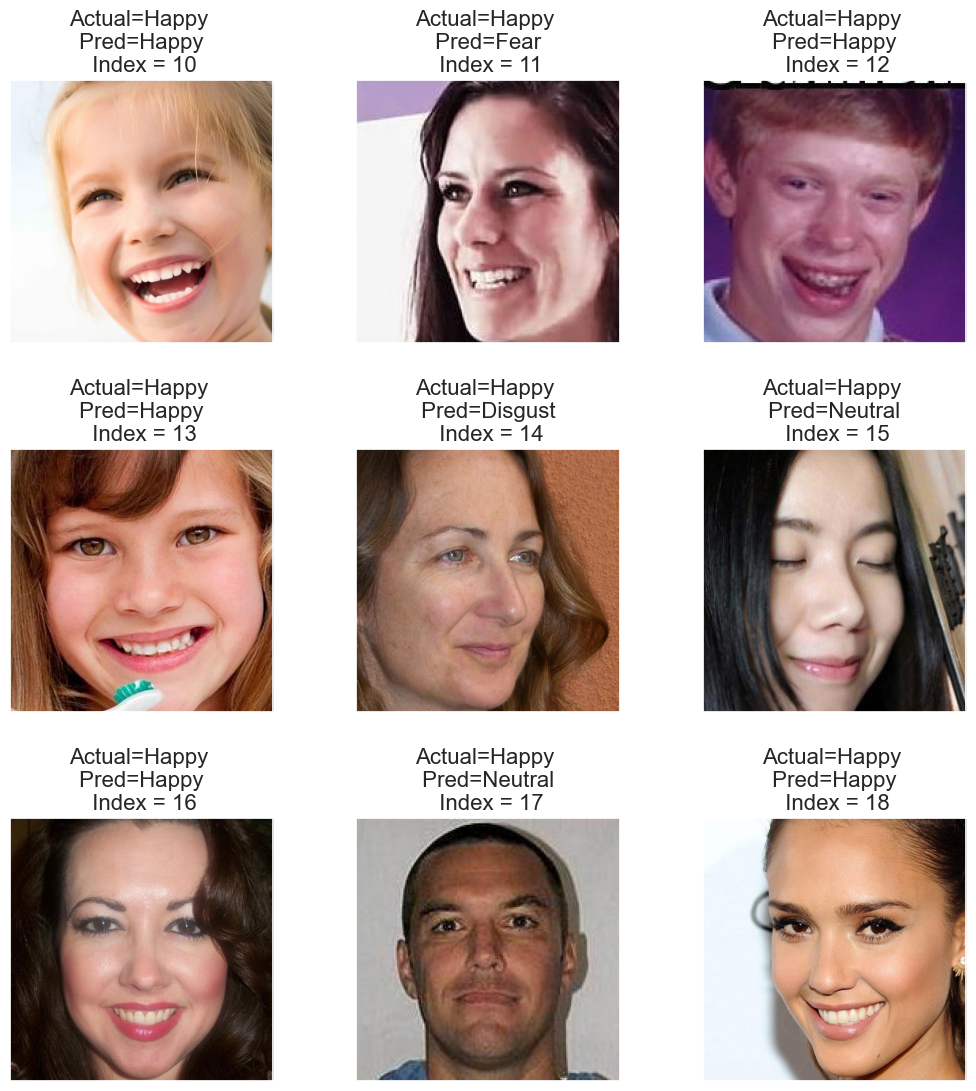

In [12]:
start=10
img_utils.display_nine_images(images, df_xai['class'], df_xai['xgb_pred'], start)

### Generate Explanations

More to come in the tutorial...

## XAI for FER with  Convoluational Neural Nets

### Setup the Pytorch Data Loader

In [14]:
# Setup XAI Data from AffectNet Deep Learning Model
TRAIN_MEAN = [0.485, 0.456, 0.406]
TRAIN_STD = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    transforms.Resize((224, 224))
])

data_dir = base_dir / 'affectnet/val_class'
dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)
dataloader = DataLoader(dataset, batch_size=80, shuffle=False)

### Load Pretrained Model

In [15]:
# download checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/0tAa2wPhGxSDjbM/download'
ckpt_path = utils.download_file(ckpt_link,
                                'affectnet.pth',
                                cache_dir= base_dir / 'affectnet/model',
                                extract=False,
                                force_download=False
                                )
ckpt_path

File already exists at: ../data/affectnet/model/affectnet.pth


PosixPath('../data/affectnet/model/affectnet.pth')

In [16]:
model = models.ResNet18(n_classes=len(class_names), pretrained=True)
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))

/Users/djohnson/micromamba/envs/wise24_xai_ac/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


<All keys matched successfully>

### Evaluation of Model

This model performs much better than the AU dataset, but still with only around $60\%$ accuracy.  But this is pretty close the state-of-the-art for the AffectNet dataset

In [17]:
inverse_weights = torch.from_numpy(1.0/np.array([74874, 134415, 25459, 14090, 6378, 3803, 24882, 3750])).type(torch.float32)
loss = torch.nn.CrossEntropyLoss(weight=inverse_weights)
_, _, preds, probs = evaluate.evaluate_model(model, dataloader, loss, device='cpu')

# store predictions in the XAI dataframe
df_xai['cnn_pred'] = preds
# validate stored preds
(df_xai['class'] == df_xai['cnn_pred']).mean()

Evaluation Loss: 1.3183, Evaluation Accuracy: 0.5875


0.5875

### Preview the Dataset with Predictions

The code below will display images from the XAI dataset.
- Try changing value of `start` to get a new set of images (there are 10 images for each class; for example, the class happy will be at indexes 10-19)
- Search through the images to find some that might be interesting to Explain

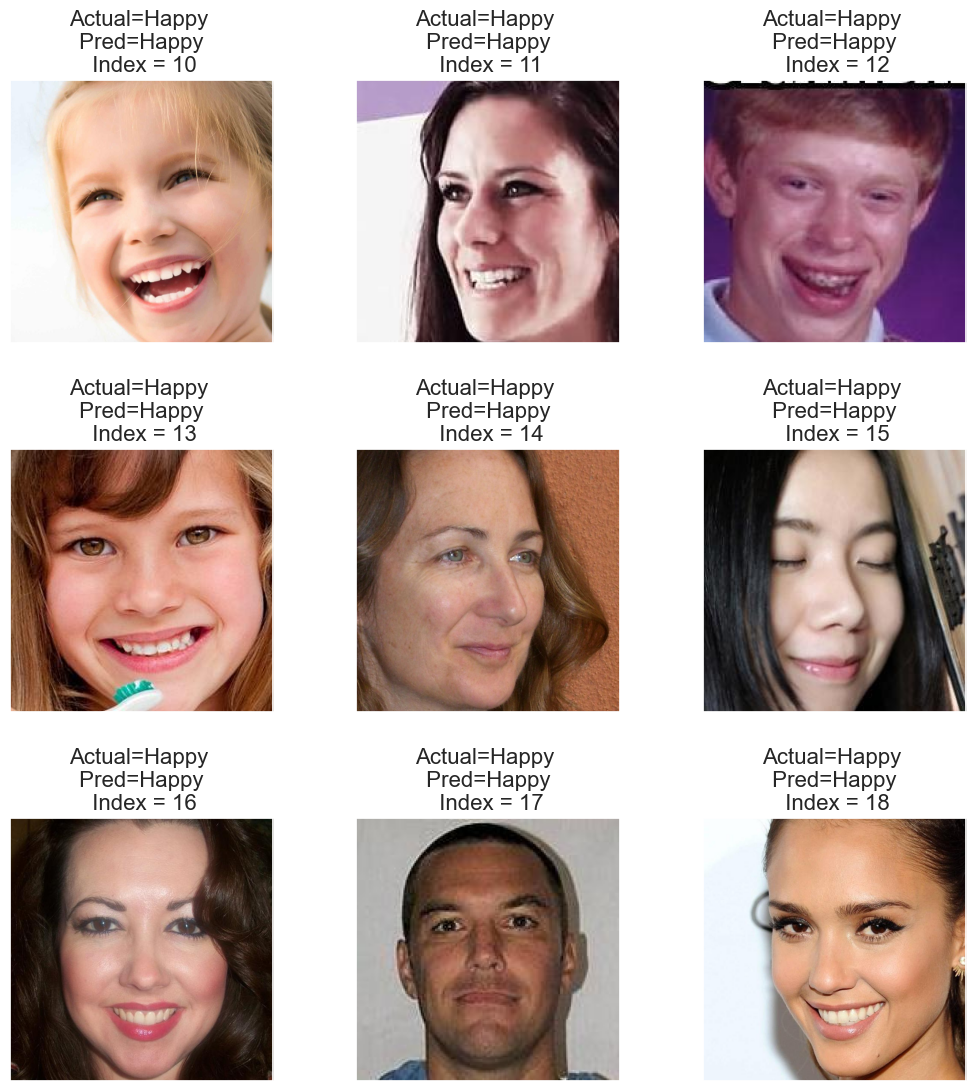

In [18]:
start=10
img_utils.display_nine_images(images, df_xai['class'], df_xai['cnn_pred'], start)

### Generate Explanations

More to come in the tuturial